In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

In [2]:
d_model = 3
n_classes = 2
img_size = (16,16)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.004

In [3]:
ds = Dataset()

In [4]:
masks = ds.load_cmb_masks()
cases = ds.load_skullstripped_mri()
# cases = ds.load_raw_mri(cohort_num=1)

In [5]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [6]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

In [7]:
sample_output = [
    
]

In [8]:
# cropped_locations = dataset.get_cropped_locations(img=dataset[0][0], x_min=164, y_min=327, x_max=172, y_max=336)
cropped_locations = dataset.get_cropped_locations(img=dataset[0][0], x_min=160, y_min=324, x_max=176, y_max=340)

In [9]:
cropped_labels = dataset.get_cropped_locations(img=dataset[0][1], x_min=263, y_min=215, x_max=279, y_max=231)

In [10]:
cropped_labels.__len__()

35

In [11]:
print(cropped_labels.__len__())

35


In [12]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
72


In [13]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [14]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

In [15]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    val_dataset, 
    shuffle=False, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
transformer = VisionTransformer(
    d_model=d_model,
    n_classes=n_classes,
    img_size=img_size,
    patch_size=patch_size,
    n_channels=n_channels,
    n_heads=n_heads,
    n_layers=n_layers,
    device=device
)

In [18]:
transformer = transformer.to(device)

In [19]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

In [24]:
from tqdm.auto import tqdm

for epoch in range(epochs):
    training_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_loader, 0),
        total=len(train_loader),
        desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}'
    )
    
    for i, data in progress_bar:
        # num_slices = len(data[0])

        cropped_images = dataset.get_cropped_locations(img=data[0], x_min=160, y_min=324, x_max=176, y_max=340)
        cropped_labels = dataset.get_cropped_locations(img=data[1], x_min=160, y_min=324, x_max=176, y_max=340)

        num_slices = len(cropped_images)
        # print(num_slices)
        
        for j in range(num_slices):
            # print(cropped_images[0][0].shape)
            # print(data[0][j].shape)
            # print(data[1][j].shape)
            
            inputs = cropped_images[j].unsqueeze(0).unsqueeze(0).float().to(device)
            labels = cropped_labels[j].unsqueeze(0).float().to(device)

            # print(inputs.shape)
            # print(labels.shape)
            
            
            print('-----------------------')
            print(f'Learning case {i} slice {j}')
            
            optimizer.zero_grad()
            outputs, loss = transformer(inputs, labels)
            outputs = F.interpolate(
                outputs,
                size=img_size,
                mode='bilinear',
                align_corners=False
            )
            
            if labels.max() >= n_classes:
                labels = torch.clamp(labels, 0, n_classes-1)
                
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss:.3f}')

Epoch 1/3 loss: 0.000:   0%|          | 0/57 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 1
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 2
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 3
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 4
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 5
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 6
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 7
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 8
Loss:  tensor(0.

Epoch 1/3 loss: 0.000:   2%|▏         | 1/57 [00:05<05:23,  5.78s/it]

tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 0
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 1
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 2
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 3
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 4
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 5
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 6
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 7
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--

Epoch 1/3 loss: 0.000:   4%|▎         | 2/57 [00:06<02:44,  3.00s/it]

-----------------------
Learning case 2 slice 0
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 1
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 2
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 3
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 4
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 5
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 6
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 7
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 8
Loss:  tensor(0.

Epoch 1/3 loss: 0.000:   5%|▌         | 3/57 [00:07<01:49,  2.02s/it]

-----------------------
Learning case 2 slice 33
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 34
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 35
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 0
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 1
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 2
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 3
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 4
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 5
Loss:  tensor

Epoch 1/3 loss: 0.000:   7%|▋         | 4/57 [00:08<01:27,  1.66s/it]

-----------------------
Learning case 3 slice 30
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 31
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 32
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 33
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 34
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 35
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 36
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 37
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 38
Loss:  

Epoch 1/3 loss: 0.000:   9%|▉         | 5/57 [00:14<02:46,  3.19s/it]

-----------------------
Learning case 4 slice 182
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 183
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 184
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 185
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 186
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 187
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 188
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 189
Loss:  tensor(0.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 19

Epoch 1/3 loss: 0.000:  11%|█         | 6/57 [00:20<03:24,  4.01s/it]

-----------------------
Learning case 5 slice 182
Loss:  tensor(9.5124e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 183
Loss:  tensor(9.5124e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 184
Loss:  tensor(9.5005e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 185
Loss:  tensor(9.5005e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 186
Loss:  tensor(9.5005e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 187
Loss:  tensor(9.5005e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 188
Loss:  tensor(9.5005e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 189
Loss:  tensor(9.4886e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 1/3 loss: 0.000:  12%|█▏        | 7/57 [00:21<02:30,  3.01s/it]

-----------------------
Learning case 6 slice 34
Loss:  tensor(9.3575e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 35
Loss:  tensor(9.3575e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 36
Loss:  tensor(9.3575e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 37
Loss:  tensor(9.3456e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 38
Loss:  tensor(9.3337e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 0
Loss:  tensor(9.3337e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 1
Loss:  tensor(9.3337e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 2
Loss:  tensor(9.3337e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Lea

Epoch 1/3 loss: 0.000:  14%|█▍        | 8/57 [00:22<01:58,  2.41s/it]

-----------------------
Learning case 7 slice 32
Loss:  tensor(9.2264e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 33
Loss:  tensor(9.2264e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 34
Loss:  tensor(9.2145e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 0
Loss:  tensor(9.2145e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 1
Loss:  tensor(9.2145e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 2
Loss:  tensor(9.2145e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 3
Loss:  tensor(9.2025e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 4
Loss:  tensor(9.1906e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learn

Epoch 1/3 loss: 0.000:  16%|█▌        | 9/57 [00:28<02:45,  3.45s/it]

Loss:  tensor(8.5589e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 191
Loss:  tensor(8.5589e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 0
Loss:  tensor(8.5469e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 1
Loss:  tensor(8.5469e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 2
Loss:  tensor(8.5469e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 3
Loss:  tensor(8.5350e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 4
Loss:  tensor(8.5350e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 5
Loss:  tensor(8.5350e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 6
Loss:  tensor(8.5350e-05, devi

Epoch 1/3 loss: 0.000:  18%|█▊        | 10/57 [00:29<02:06,  2.69s/it]

-----------------------
Learning case 9 slice 31
Loss:  tensor(8.4516e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 32
Loss:  tensor(8.4516e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 33
Loss:  tensor(8.4397e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 34
Loss:  tensor(8.4277e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 35
Loss:  tensor(8.4277e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 36
Loss:  tensor(8.4277e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 37
Loss:  tensor(8.4277e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 38
Loss:  tensor(8.4277e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000:  19%|█▉        | 11/57 [00:30<01:39,  2.16s/it]

-----------------------
Learning case 10 slice 31
Loss:  tensor(8.3205e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 32
Loss:  tensor(8.3205e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 33
Loss:  tensor(8.3085e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 34
Loss:  tensor(8.3085e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 35
Loss:  tensor(8.3085e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 36
Loss:  tensor(8.3085e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 37
Loss:  tensor(8.3085e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 38
Loss:  tensor(8.2966e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 1/3 loss: 0.000:  21%|██        | 12/57 [00:35<02:20,  3.12s/it]

Loss:  tensor(7.7006e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 186
Loss:  tensor(7.7006e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 187
Loss:  tensor(7.7006e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 188
Loss:  tensor(7.7006e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 189
Loss:  tensor(7.7006e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 190
Loss:  tensor(7.6887e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 191
Loss:  tensor(7.6887e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 0
Loss:  tensor(7.6887e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 1
Loss:  tenso

Epoch 1/3 loss: 0.000:  23%|██▎       | 13/57 [00:36<01:47,  2.45s/it]

Loss:  tensor(7.5814e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 35
Loss:  tensor(7.5814e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 36
Loss:  tensor(7.5814e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 37
Loss:  tensor(7.5695e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 38
Loss:  tensor(7.5695e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 0
Loss:  tensor(7.5695e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 1
Loss:  tensor(7.5695e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 2
Loss:  tensor(7.5695e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 3
Loss:  tensor(7.5695

Epoch 1/3 loss: 0.000:  25%|██▍       | 14/57 [00:43<02:43,  3.81s/it]

Loss:  tensor(7.0093e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 189
Loss:  tensor(7.0093e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 190
Loss:  tensor(7.0093e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 191
Loss:  tensor(7.0093e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 0
Loss:  tensor(7.0093e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 1
Loss:  tensor(7.0093e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 2
Loss:  tensor(6.9973e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 3
Loss:  tensor(6.9973e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 4
Loss:  tensor(6.99

Epoch 1/3 loss: 0.000:  26%|██▋       | 15/57 [00:44<02:06,  3.01s/it]

-----------------------
Learning case 14 slice 35
Loss:  tensor(6.9139e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 36
Loss:  tensor(6.9139e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 37
Loss:  tensor(6.9139e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 38
Loss:  tensor(6.9020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 0
Loss:  tensor(6.9020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 1
Loss:  tensor(6.9020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 2
Loss:  tensor(6.8901e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 3
Loss:  tensor(6.8901e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 1/3 loss: 0.000:  28%|██▊       | 16/57 [00:51<02:52,  4.22s/it]

-----------------------
Learning case 15 slice 190
Loss:  tensor(6.3894e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 191
Loss:  tensor(6.3894e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 0
Loss:  tensor(6.3894e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 1
Loss:  tensor(6.3775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 2
Loss:  tensor(6.3656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 3
Loss:  tensor(6.3656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 4
Loss:  tensor(6.3656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 5
Loss:  tensor(6.3656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 1/3 loss: 0.000:  30%|██▉       | 17/57 [00:58<03:18,  4.97s/it]

-----------------------
Learning case 16 slice 185
Loss:  tensor(5.9126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 186
Loss:  tensor(5.9126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 187
Loss:  tensor(5.9126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 188
Loss:  tensor(5.9126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 189
Loss:  tensor(5.9007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 190
Loss:  tensor(5.9007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 191
Loss:  tensor(5.9007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 0
Loss:  tensor(5.9007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 1/3 loss: 0.000:  32%|███▏      | 18/57 [01:04<03:28,  5.34s/it]

-----------------------
Learning case 17 slice 186
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 187
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 188
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 189
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 190
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 191
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 0
Loss:  tensor(5.4477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 1
Loss:  tensor(5.4358e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------

Epoch 1/3 loss: 0.000:  33%|███▎      | 19/57 [01:10<03:30,  5.53s/it]

-----------------------
Learning case 19 slice 0
Loss:  tensor(5.0186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 1
Loss:  tensor(5.0186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 2
Loss:  tensor(5.0186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 3
Loss:  tensor(5.0067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 4
Loss:  tensor(5.0067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 5
Loss:  tensor(5.0067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 6
Loss:  tensor(5.0067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 7
Loss:  tensor(5.0067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000:  35%|███▌      | 20/57 [01:11<02:36,  4.23s/it]

-----------------------
Learning case 19 slice 30
Loss:  tensor(4.9590e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 31
Loss:  tensor(4.9590e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 32
Loss:  tensor(4.9471e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 33
Loss:  tensor(4.9471e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 34
Loss:  tensor(4.9471e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 0
Loss:  tensor(4.9471e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 1
Loss:  tensor(4.9471e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 2
Loss:  tensor(4.9471e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-------------------

Epoch 1/3 loss: 0.000:  37%|███▋      | 21/57 [01:12<01:58,  3.30s/it]

-----------------------
Learning case 20 slice 31
Loss:  tensor(4.8875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 32
Loss:  tensor(4.8875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 33
Loss:  tensor(4.8875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 34
Loss:  tensor(4.8875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 0
Loss:  tensor(4.8636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 1
Loss:  tensor(4.8636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 2
Loss:  tensor(4.8636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 3
Loss:  tensor(4.8636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 1/3 loss: 0.000:  39%|███▊      | 22/57 [01:13<01:34,  2.71s/it]

-----------------------
Learning case 21 slice 39
Loss:  tensor(4.7921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 40
Loss:  tensor(4.7921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 41
Loss:  tensor(4.7921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 42
Loss:  tensor(4.7921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 43
Loss:  tensor(4.7921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 44
Loss:  tensor(4.7921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 45
Loss:  tensor(4.7802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 46
Loss:  tensor(4.7802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 1/3 loss: 0.000:  40%|████      | 23/57 [01:20<02:10,  3.83s/it]

-----------------------
Learning case 22 slice 185
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 186
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 187
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 188
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 189
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 190
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 191
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 0
Loss:  tensor(4.3987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 1/3 loss: 0.000:  42%|████▏     | 24/57 [01:21<01:38,  3.00s/it]

-----------------------
Learning case 23 slice 29
Loss:  tensor(4.3391e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 30
Loss:  tensor(4.3391e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 31
Loss:  tensor(4.3391e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 32
Loss:  tensor(4.3391e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 33
Loss:  tensor(4.3391e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 34
Loss:  tensor(4.3272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 35
Loss:  tensor(4.3272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 36
Loss:  tensor(4.3272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 1/3 loss: 0.000:  44%|████▍     | 25/57 [01:27<02:05,  3.91s/it]

-----------------------
Learning case 25 slice 0
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 1
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 2
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 3
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 4
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 5
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 6
Loss:  tensor(3.9696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 7
Loss:  tensor(3.9577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000:  46%|████▌     | 26/57 [01:33<02:22,  4.61s/it]

Loss:  tensor(3.6716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 184
Loss:  tensor(3.6716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 185
Loss:  tensor(3.6716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 186
Loss:  tensor(3.6716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 187
Loss:  tensor(3.6716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 188
Loss:  tensor(3.6597e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 189
Loss:  tensor(3.6597e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 190
Loss:  tensor(3.6597e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 191
Loss:  t

Epoch 1/3 loss: 0.000:  47%|████▋     | 27/57 [01:39<02:28,  4.95s/it]

-----------------------
Learning case 26 slice 186
Loss:  tensor(3.3736e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 187
Loss:  tensor(3.3736e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 188
Loss:  tensor(3.3736e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 189
Loss:  tensor(3.3736e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 190
Loss:  tensor(3.3616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 191
Loss:  tensor(3.3616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 0
Loss:  tensor(3.3616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 1
Loss:  tensor(3.3616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------

Epoch 1/3 loss: 0.000:  49%|████▉     | 28/57 [01:40<01:50,  3.81s/it]

-----------------------
Learning case 27 slice 37
Loss:  tensor(3.3140e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 38
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 0
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 1
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 2
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 3
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 4
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 5
Loss:  tensor(3.3020e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 1/3 loss: 0.000:  51%|█████     | 29/57 [01:41<01:25,  3.05s/it]

Loss:  tensor(3.2663e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 28
Loss:  tensor(3.2663e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 29
Loss:  tensor(3.2663e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 30
Loss:  tensor(3.2544e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 31
Loss:  tensor(3.2544e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 32
Loss:  tensor(3.2544e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 33
Loss:  tensor(3.2544e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 34
Loss:  tensor(3.2544e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 0
Loss:  tensor(3.2

Epoch 1/3 loss: 0.000:  53%|█████▎    | 30/57 [01:48<01:50,  4.10s/it]

-----------------------
Learning case 29 slice 185
Loss:  tensor(3.0040e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 186
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 187
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 188
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 189
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 190
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 191
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 0
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 1/3 loss: 0.000:  54%|█████▍    | 31/57 [01:54<02:01,  4.67s/it]

-----------------------
Learning case 30 slice 183
Loss:  tensor(2.7537e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 184
Loss:  tensor(2.7537e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 185
Loss:  tensor(2.7537e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 186
Loss:  tensor(2.7537e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 187
Loss:  tensor(2.7537e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 188
Loss:  tensor(2.7418e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 189
Loss:  tensor(2.7418e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 190
Loss:  tensor(2.7299e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 1/3 loss: 0.000:  56%|█████▌    | 32/57 [02:00<02:05,  5.01s/it]

Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 185
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 186
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 187
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 188
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 189
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 190
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 191
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 0
Loss:  ten

Epoch 1/3 loss: 0.000:  58%|█████▊    | 33/57 [02:01<01:31,  3.79s/it]

-----------------------
Learning case 32 slice 30
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 31
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 32
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 33
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 34
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 35
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 0
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 1
Loss:  tensor(2.4676e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 1/3 loss: 0.000:  60%|█████▉    | 34/57 [02:07<01:41,  4.39s/it]

-----------------------
Learning case 33 slice 187
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 188
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 189
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 190
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 191
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 0
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 1
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 2
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 1/3 loss: 0.000:  61%|██████▏   | 35/57 [02:08<01:14,  3.41s/it]

-----------------------
Learning case 34 slice 31
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 32
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 33
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 34
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 0
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 1
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 2
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 3
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 1/3 loss: 0.000:  63%|██████▎   | 36/57 [02:09<00:56,  2.70s/it]

-----------------------
Learning case 35 slice 31
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 32
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 33
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 34
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 35
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 36
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 37
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 38
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 1/3 loss: 0.000:  65%|██████▍   | 37/57 [02:10<00:43,  2.19s/it]

-----------------------
Learning case 36 slice 34
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 0
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 1
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 2
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 3
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 4
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 5
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 6
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------

Epoch 1/3 loss: 0.000:  67%|██████▋   | 38/57 [02:15<01:01,  3.21s/it]

-----------------------
Learning case 37 slice 191
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 0
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 1
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 2
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 3
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 4
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 5
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 6
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 1/3 loss: 0.000:  68%|██████▊   | 39/57 [02:16<00:45,  2.54s/it]

-----------------------
Learning case 38 slice 34
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 35
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 36
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 37
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 38
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 0
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 1
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 2
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-------------------

Epoch 1/3 loss: 0.000:  70%|███████   | 40/57 [02:22<01:00,  3.56s/it]

-----------------------
Learning case 39 slice 190
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 191
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 0
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 1
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 2
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 3
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 4
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 5
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 1/3 loss: 0.000:  72%|███████▏  | 41/57 [02:23<00:46,  2.88s/it]

-----------------------
Learning case 41 slice 0
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 1
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 2
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 3
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 4
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 5
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 6
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 7
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000:  74%|███████▎  | 42/57 [02:25<00:35,  2.38s/it]

Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 34
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 35
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 36
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 37
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 38
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 0
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 1
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 2
Loss:  tensor(1.704

Epoch 1/3 loss: 0.000:  75%|███████▌  | 43/57 [02:31<00:48,  3.46s/it]

Loss:  tensor(1.5616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 191
Loss:  tensor(1.5616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 0
Loss:  tensor(1.5616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 1
Loss:  tensor(1.5616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 2
Loss:  tensor(1.5616e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 3
Loss:  tensor(1.5497e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 4
Loss:  tensor(1.5497e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 5
Loss:  tensor(1.5497e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 6
Loss:  tensor(1.5497e-

Epoch 1/3 loss: 0.000:  77%|███████▋  | 44/57 [02:38<00:59,  4.58s/it]

Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 189
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 190
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 191
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 0
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 1
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 2
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 3
Loss:  tensor(1.4186e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 4
Loss:  tensor(1.41

Epoch 1/3 loss: 0.000:  79%|███████▉  | 45/57 [02:39<00:43,  3.64s/it]

Loss:  tensor(1.4067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 32
Loss:  tensor(1.4067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 33
Loss:  tensor(1.4067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 34
Loss:  tensor(1.4067e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 0
Loss:  tensor(1.3947e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 1
Loss:  tensor(1.3947e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 2
Loss:  tensor(1.3947e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 3
Loss:  tensor(1.3947e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 4
Loss:  tensor(1.3947e

Epoch 1/3 loss: 0.000:  81%|████████  | 46/57 [02:41<00:33,  3.05s/it]

-----------------------
Learning case 45 slice 37
Loss:  tensor(1.3828e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 38
Loss:  tensor(1.3828e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 0
Loss:  tensor(1.3828e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 1
Loss:  tensor(1.3828e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 2
Loss:  tensor(1.3828e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 3
Loss:  tensor(1.3828e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 4
Loss:  tensor(1.3709e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 5
Loss:  tensor(1.3709e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 1/3 loss: 0.000:  82%|████████▏ | 47/57 [02:48<00:41,  4.11s/it]

-----------------------
Learning case 46 slice 186
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 187
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 188
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 189
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 190
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 191
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 0
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 1
Loss:  tensor(1.2517e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------

Epoch 1/3 loss: 0.000:  84%|████████▍ | 48/57 [02:49<00:28,  3.17s/it]

-----------------------
Learning case 47 slice 31
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 32
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 33
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 34
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 35
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 36
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 37
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 38
Loss:  tensor(1.2398e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 1/3 loss: 0.000:  86%|████████▌ | 49/57 [02:54<00:31,  3.98s/it]

-----------------------
Learning case 48 slice 187
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 188
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 189
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 190
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 191
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 0
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 1
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 2
Loss:  tensor(1.1325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 1/3 loss: 0.000:  88%|████████▊ | 50/57 [03:01<00:32,  4.62s/it]

-----------------------
Learning case 50 slice 0
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 1
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 2
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 3
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 4
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 5
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 6
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 7
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000:  89%|████████▉ | 51/57 [03:07<00:30,  5.14s/it]

Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 0
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 1
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 2
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 3
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 4
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 5
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 6
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 7
Loss:  tensor(1.7047e-05

Epoch 1/3 loss: 0.000:  91%|█████████ | 52/57 [03:08<00:19,  3.94s/it]

Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 37
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 38
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 0
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 1
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 2
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 3
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 4
Loss:  tensor(1.7047e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 5
Loss:  tensor(1.7047e-

Epoch 1/3 loss: 0.000:  93%|█████████▎| 53/57 [03:09<00:12,  3.14s/it]

-----------------------
Learning case 52 slice 36
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 37
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 38
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 0
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 1
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 2
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 3
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 4
Loss:  tensor(1.6808e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
---------------------

Epoch 1/3 loss: 0.000:  95%|█████████▍| 54/57 [03:11<00:07,  2.62s/it]

-----------------------
Learning case 54 slice 0
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 1
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 2
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 3
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 4
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 5
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 6
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 7
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000:  96%|█████████▋| 55/57 [03:12<00:04,  2.30s/it]

Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 35
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 36
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 37
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 38
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 0
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 1
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 2
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 3
Loss:  tensor(2.1934

Epoch 1/3 loss: 0.000:  98%|█████████▊| 56/57 [03:14<00:01,  1.99s/it]

-----------------------
Learning case 56 slice 0
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 1
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 2
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 3
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 4
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 5
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 6
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 7
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 1/3 loss: 0.000: 100%|██████████| 57/57 [03:15<00:00,  3.43s/it]


Epoch 1/3 loss: 3.633


Epoch 2/3 loss: 0.000:   0%|          | 0/57 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 1
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 2
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 3
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 4
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 5
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 6
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 7
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning

Epoch 2/3 loss: 0.000:   2%|▏         | 1/57 [00:01<01:01,  1.10s/it]

Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 31
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 32
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 33
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 34
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 35
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 36
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 37
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 38
Loss:  tensor(2.1934e-05

Epoch 2/3 loss: 0.000:   4%|▎         | 2/57 [00:07<03:38,  3.98s/it]

-----------------------
Learning case 1 slice 184
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 185
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 186
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 187
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 188
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 189
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 190
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 191
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 2/3 loss: 0.000:   5%|▌         | 3/57 [00:12<04:15,  4.73s/it]

Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 187
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 188
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 189
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 190
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 191
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 0
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 1
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 2
Loss:  tensor(2.1338e-

Epoch 2/3 loss: 0.000:   7%|▋         | 4/57 [00:18<04:33,  5.16s/it]

-----------------------
Learning case 3 slice 191
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 0
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 1
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 2
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 3
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 4
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 5
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 6
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learni

Epoch 2/3 loss: 0.000:   9%|▉         | 5/57 [00:19<03:12,  3.71s/it]

-----------------------
Learning case 4 slice 28
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 29
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 30
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 31
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 32
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 33
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 34
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 0
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
L

Epoch 2/3 loss: 0.000:  11%|█         | 6/57 [00:20<02:23,  2.80s/it]

-----------------------
Learning case 5 slice 34
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 0
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 1
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 2
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 3
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 4
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 5
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 6
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learnin

Epoch 2/3 loss: 0.000:  12%|█▏        | 7/57 [00:21<01:53,  2.26s/it]

tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 33
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 34
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 0
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 1
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 2
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 3
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 4
Loss:  tensor(2.0742e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 5
Loss:  tensor(2.0742e-05, device='cud

Epoch 2/3 loss: 0.000:  14%|█▍        | 8/57 [00:27<02:44,  3.36s/it]

-----------------------
Learning case 8 slice 0
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 1
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 2
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 3
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 4
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 5
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 6
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 7
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning

Epoch 2/3 loss: 0.000:  16%|█▌        | 9/57 [00:28<02:05,  2.61s/it]

Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 34
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 35
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 36
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 37
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 38
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 0
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 1
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 2
Loss:  tensor(2.0385e-05, d

Epoch 2/3 loss: 0.000:  18%|█▊        | 10/57 [00:34<02:46,  3.54s/it]

-----------------------
Learning case 9 slice 186
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 187
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 188
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 189
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 190
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 191
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 0
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 1
Loss:  tensor(2.0027e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 2/3 loss: 0.000:  19%|█▉        | 11/57 [00:39<03:12,  4.19s/it]

-----------------------
Learning case 10 slice 188
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 189
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 190
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 191
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 0
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 1
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 2
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 3
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 2/3 loss: 0.000:  21%|██        | 12/57 [00:40<02:25,  3.24s/it]

-----------------------
Learning case 11 slice 33
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 34
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 0
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 1
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 2
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 3
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 4
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 5
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 2/3 loss: 0.000:  23%|██▎       | 13/57 [00:46<02:57,  4.04s/it]

Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 183
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 184
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 185
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 186
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 187
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 188
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 189
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 190
Loss:  t

Epoch 2/3 loss: 0.000:  25%|██▍       | 14/57 [00:52<03:13,  4.50s/it]

Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 189
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 190
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 191
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 0
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 1
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 2
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 3
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 4
Loss:  tensor(1.89

Epoch 2/3 loss: 0.000:  26%|██▋       | 15/57 [00:57<03:22,  4.82s/it]

-----------------------
Learning case 14 slice 191
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 0
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 1
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 2
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 3
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 4
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 5
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 6
Loss:  tensor(1.8596e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 2/3 loss: 0.000:  28%|██▊       | 16/57 [01:03<03:27,  5.06s/it]

Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 186
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 187
Loss:  tensor(1.8120e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 188
Loss:  tensor(1.8120e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 189
Loss:  tensor(1.8120e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 190
Loss:  tensor(1.8120e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 191
Loss:  tensor(1.8120e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 0
Loss:  tensor(1.8120e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 1
Loss:  tenso

Epoch 2/3 loss: 0.000:  30%|██▉       | 17/57 [01:09<03:32,  5.30s/it]

-----------------------
Learning case 16 slice 185
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 186
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 187
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 188
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 189
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 190
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 191
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 0
Loss:  tensor(1.7881e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 2/3 loss: 0.000:  32%|███▏      | 18/57 [01:10<02:36,  4.01s/it]

-----------------------
Learning case 17 slice 33
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 34
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 35
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 36
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 37
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 38
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 0
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 1
Loss:  tensor(1.7643e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 2/3 loss: 0.000:  33%|███▎      | 19/57 [01:16<02:51,  4.51s/it]

-----------------------
Learning case 18 slice 186
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 187
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 188
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 189
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 190
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 191
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 0
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 1
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------

Epoch 2/3 loss: 0.000:  35%|███▌      | 20/57 [01:17<02:08,  3.48s/it]

-----------------------
Learning case 19 slice 28
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 29
Loss:  tensor(1.8954e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 30
Loss:  tensor(1.9073e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 31
Loss:  tensor(1.9193e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 32
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 33
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 34
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 35
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 2/3 loss: 0.000:  37%|███▋      | 21/57 [01:22<02:28,  4.13s/it]

-----------------------
Learning case 20 slice 185
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 186
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 187
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 188
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 189
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 190
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 191
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 0
Loss:  tensor(1.9789e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 2/3 loss: 0.000:  39%|███▊      | 22/57 [01:23<01:51,  3.19s/it]

tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 33
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 34
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 35
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 36
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 37
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 38
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 0
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 1
Loss:  tensor(1.9669e-05,

Epoch 2/3 loss: 0.000:  40%|████      | 23/57 [01:24<01:26,  2.54s/it]

-----------------------
Learning case 23 slice 0
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 1
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 2
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 3
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 4
Loss:  tensor(1.9669e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 5
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 6
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 7
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 2/3 loss: 0.000:  42%|████▏     | 24/57 [01:25<01:09,  2.10s/it]

-----------------------
Learning case 24 slice 0
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 1
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 2
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 3
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 4
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 5
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 6
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 7
Loss:  tensor(1.9550e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 2/3 loss: 0.000:  44%|████▍     | 25/57 [01:26<00:57,  1.80s/it]

tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 29
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 30
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 31
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 32
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 33
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 34
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 0
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 1
Loss:  tensor(1.9431e-05,

Epoch 2/3 loss: 0.000:  46%|████▌     | 26/57 [01:27<00:48,  1.57s/it]

-----------------------
Learning case 25 slice 34
Loss:  tensor(1.9431e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 0
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 1
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 2
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 3
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 4
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 5
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 6
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------

Epoch 2/3 loss: 0.000:  47%|████▋     | 27/57 [01:33<01:20,  2.68s/it]

Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 0
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 1
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 2
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 3
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 4
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 5
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 6
Loss:  tensor(1.8835e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 7
Loss:  tensor(1.8835e-05

Epoch 2/3 loss: 0.000:  49%|████▉     | 28/57 [01:34<01:03,  2.20s/it]

Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 37
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 38
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 0
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 1
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 2
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 3
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 4
Loss:  tensor(1.8716e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 5
Loss:  tensor(1.8716e-

Epoch 2/3 loss: 0.000:  51%|█████     | 29/57 [01:35<00:51,  1.85s/it]

-----------------------
Learning case 28 slice 32
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 33
Loss:  tensor(2.3365e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 34
Loss:  tensor(2.3365e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 0
Loss:  tensor(2.3365e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 1
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 2
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 3
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 4
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
---------------------

Epoch 2/3 loss: 0.000:  53%|█████▎    | 30/57 [01:36<00:44,  1.66s/it]

-----------------------
Learning case 29 slice 31
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 32
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 33
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 34
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 0
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 1
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 2
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 3
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 2/3 loss: 0.000:  54%|█████▍    | 31/57 [01:42<01:14,  2.85s/it]

Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 190
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 191
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 0
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 1
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 2
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 3
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 4
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 5
Loss:  tensor(2.3484

Epoch 2/3 loss: 0.000:  56%|█████▌    | 32/57 [01:43<00:58,  2.32s/it]

-----------------------
Learning case 32 slice 0
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 1
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 2
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 3
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 4
Loss:  tensor(2.3484e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 5
Loss:  tensor(2.3365e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 6
Loss:  tensor(2.3365e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 7
Loss:  tensor(2.3365e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 2/3 loss: 0.000:  58%|█████▊    | 33/57 [01:49<01:21,  3.38s/it]

-----------------------
Learning case 32 slice 181
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 182
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 183
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 184
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 185
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 186
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 187
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 188
Loss:  tensor(2.3246e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 2/3 loss: 0.000:  60%|█████▉    | 34/57 [01:50<01:01,  2.67s/it]

-----------------------
Learning case 33 slice 31
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 32
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 33
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 34
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 35
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 36
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 37
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 38
Loss:  tensor(2.3126e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 2/3 loss: 0.000:  61%|██████▏   | 35/57 [01:55<01:18,  3.58s/it]

-----------------------
Learning case 34 slice 186
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 187
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 188
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 189
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 190
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 191
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 0
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 1
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------

Epoch 2/3 loss: 0.000:  63%|██████▎   | 36/57 [01:57<01:00,  2.86s/it]

Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 45
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 46
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 47
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 0
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 1
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 2
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 3
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 4
Loss:  tensor(2.2650e

Epoch 2/3 loss: 0.000:  65%|██████▍   | 37/57 [01:58<00:47,  2.39s/it]

-----------------------
Learning case 36 slice 40
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 41
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 42
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 43
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 44
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 45
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 46
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 47
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 2/3 loss: 0.000:  67%|██████▋   | 38/57 [01:59<00:37,  1.98s/it]

-----------------------
Learning case 37 slice 33
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 34
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 35
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 36
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 37
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 38
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 0
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 1
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 2/3 loss: 0.000:  68%|██████▊   | 39/57 [02:05<00:56,  3.12s/it]

Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 184
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 185
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 186
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 187
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 188
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 189
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 190
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 191
Loss:  t

Epoch 2/3 loss: 0.000:  70%|███████   | 40/57 [02:06<00:41,  2.46s/it]

-----------------------
Learning case 39 slice 32
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 33
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 34
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 35
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 0
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 1
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 2
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 3
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 2/3 loss: 0.000:  72%|███████▏  | 41/57 [02:07<00:32,  2.05s/it]

-----------------------
Learning case 40 slice 32
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 33
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 34
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 0
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 1
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 2
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 3
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 4
Loss:  tensor(2.2173e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
---------------------

Epoch 2/3 loss: 0.000:  74%|███████▎  | 42/57 [02:12<00:47,  3.13s/it]

-----------------------
Learning case 41 slice 191
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 0
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 1
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 2
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 3
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 4
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 5
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 6
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 2/3 loss: 0.000:  75%|███████▌  | 43/57 [02:18<00:54,  3.92s/it]

-----------------------
Learning case 42 slice 187
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 188
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 189
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 190
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 191
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 0
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 1
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 2
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 2/3 loss: 0.000:  77%|███████▋  | 44/57 [02:19<00:39,  3.06s/it]

-----------------------
Learning case 44 slice 0
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 1
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 2
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 3
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 4
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 5
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 6
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 7
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 2/3 loss: 0.000:  79%|███████▉  | 45/57 [02:20<00:29,  2.47s/it]

-----------------------
Learning case 44 slice 38
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 0
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 1
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 2
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 3
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 4
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 5
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 6
Loss:  tensor(2.1219e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------

Epoch 2/3 loss: 0.000:  81%|████████  | 46/57 [02:26<00:37,  3.45s/it]

-----------------------
Learning case 45 slice 185
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 186
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 187
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 188
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 189
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 190
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 191
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 0
Loss:  tensor(2.0861e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 2/3 loss: 0.000:  82%|████████▏ | 47/57 [02:32<00:41,  4.11s/it]

-----------------------
Learning case 46 slice 184
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 185
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 186
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 187
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 188
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 189
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 190
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 191
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 2/3 loss: 0.000:  84%|████████▍ | 48/57 [02:38<00:41,  4.64s/it]

-----------------------
Learning case 48 slice 0
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 1
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 2
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 3
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 4
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 5
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 6
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 7
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 2/3 loss: 0.000:  86%|████████▌ | 49/57 [02:38<00:28,  3.53s/it]

-----------------------
Learning case 48 slice 33
Loss:  tensor(3.0875e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 34
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 35
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 36
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 37
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 38
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 0
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 1
Loss:  tensor(3.0756e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 2/3 loss: 0.000:  88%|████████▊ | 50/57 [02:44<00:29,  4.23s/it]

-----------------------
Learning case 49 slice 181
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 182
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 183
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 184
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 185
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 186
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 187
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 188
Loss:  tensor(3.0279e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 2/3 loss: 0.000:  89%|████████▉ | 51/57 [02:45<00:19,  3.28s/it]

-----------------------
Learning case 50 slice 33
Loss:  tensor(3.0159e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 34
Loss:  tensor(3.0159e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 0
Loss:  tensor(3.0159e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 1
Loss:  tensor(3.0040e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 2
Loss:  tensor(3.0040e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 3
Loss:  tensor(3.0040e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 4
Loss:  tensor(3.0040e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 5
Loss:  tensor(3.0040e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 2/3 loss: 0.000:  91%|█████████ | 52/57 [02:51<00:20,  4.02s/it]

-----------------------
Learning case 51 slice 184
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 185
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 186
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 187
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 188
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 189
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 190
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 191
Loss:  tensor(2.9444e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 2/3 loss: 0.000:  93%|█████████▎| 53/57 [02:52<00:12,  3.14s/it]

-----------------------
Learning case 53 slice 0
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 1
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 2
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 3
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 4
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 5
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 6
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 7
Loss:  tensor(2.9325e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 2/3 loss: 0.000:  95%|█████████▍| 54/57 [02:58<00:11,  3.91s/it]

Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 185
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 186
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 187
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 188
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 189
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 190
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 191
Loss:  tensor(2.8729e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 0
Loss:  ten

Epoch 2/3 loss: 0.000:  96%|█████████▋| 55/57 [02:59<00:06,  3.04s/it]

Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 28
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 29
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 30
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 31
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 32
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 33
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 34
Loss:  tensor(2.8491e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 35
Loss:  tensor(2.

Epoch 2/3 loss: 0.000:  98%|█████████▊| 56/57 [03:00<00:02,  2.46s/it]

tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 32
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 33
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 34
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 35
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 36
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 37
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 38
Loss:  tensor(2.8371e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 0
Loss:  tensor(2.8371e-05

Epoch 2/3 loss: 0.000: 100%|██████████| 57/57 [03:01<00:00,  3.18s/it]


-----------------------
Learning case 56 slice 32
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 33
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 34
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 35
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 36
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 37
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 38
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Epoch 2/3 loss: 3.359


Epoch 3/3 loss: 0.000:   0%|          | 0/57 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 1
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 2
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 3
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 4
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 5
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 6
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 7
Loss:  tensor(2.8252e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning

Epoch 3/3 loss: 0.000:   2%|▏         | 1/57 [00:01<00:57,  1.03s/it]

-----------------------
Learning case 1 slice 0
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 1
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 2
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 3
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 4
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 5
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 6
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 7
Loss:  tensor(2.8133e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning

Epoch 3/3 loss: 0.000:   4%|▎         | 2/57 [00:02<01:01,  1.11s/it]

tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 31
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 32
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 33
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 34
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 0
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 1
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 2
Loss:  tensor(2.8014e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 3
Loss:  tensor(2.8014e-05, device='c

Epoch 3/3 loss: 0.000:   5%|▌         | 3/57 [00:03<00:54,  1.02s/it]

-----------------------
Learning case 2 slice 29
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 30
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 31
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 32
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 33
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 34
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 35
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 0
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
L

Epoch 3/3 loss: 0.000:   7%|▋         | 4/57 [00:04<00:56,  1.06s/it]

-----------------------
Learning case 3 slice 31
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 32
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 33
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 34
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 0
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 1
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 2
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 3
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Lear

Epoch 3/3 loss: 0.000:   9%|▉         | 5/57 [00:10<02:25,  2.80s/it]

-----------------------
Learning case 4 slice 191
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 0
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 1
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 2
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 3
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 4
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 5
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 6
Loss:  tensor(2.6941e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learni

Epoch 3/3 loss: 0.000:  11%|█         | 6/57 [00:11<01:52,  2.20s/it]

-----------------------
Learning case 5 slice 30
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 31
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 32
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 33
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 34
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 35
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 36
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 37
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  12%|█▏        | 7/57 [00:17<02:51,  3.43s/it]

-----------------------
Learning case 6 slice 190
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 191
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 0
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 1
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 2
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 3
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 4
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 5
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Lear

Epoch 3/3 loss: 0.000:  14%|█▍        | 8/57 [00:22<03:23,  4.14s/it]

Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 187
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 188
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 189
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 190
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 191
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 0
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 1
Loss:  tensor(2.5272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 2
Loss:  tensor(2.5272e-

Epoch 3/3 loss: 0.000:  16%|█▌        | 9/57 [00:23<02:30,  3.14s/it]

-----------------------
Learning case 8 slice 30
Loss:  tensor(2.5153e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 31
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 32
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 33
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 34
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 8 slice 35
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 0
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 9 slice 1
Loss:  tensor(2.5034e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Le

Epoch 3/3 loss: 0.000:  18%|█▊        | 10/57 [00:29<03:05,  3.95s/it]

-----------------------
Learning case 10 slice 0
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 1
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 2
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 3
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 4
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 5
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 6
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 7
Loss:  tensor(2.4080e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  19%|█▉        | 11/57 [00:30<02:21,  3.08s/it]

-----------------------
Learning case 10 slice 33
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 10 slice 34
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 0
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 1
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 2
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 3
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 4
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 5
Loss:  tensor(2.3961e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 3/3 loss: 0.000:  21%|██        | 12/57 [00:31<01:52,  2.50s/it]

-----------------------
Learning case 11 slice 37
Loss:  tensor(2.3842e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 11 slice 38
Loss:  tensor(2.3842e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 0
Loss:  tensor(2.3842e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 1
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 2
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 3
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 4
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 5
Loss:  tensor(2.3722e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 3/3 loss: 0.000:  23%|██▎       | 13/57 [00:37<02:31,  3.45s/it]

-----------------------
Learning case 12 slice 187
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 188
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 189
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 190
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 12 slice 191
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 0
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 1
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 2
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 3/3 loss: 0.000:  25%|██▍       | 14/57 [00:38<01:57,  2.73s/it]

-----------------------
Learning case 13 slice 30
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 31
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 32
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 33
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 34
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 35
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 36
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 13 slice 37
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  26%|██▋       | 15/57 [00:39<01:33,  2.22s/it]

Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 31
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 32
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 33
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 34
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 35
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 36
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 37
Loss:  tensor(2.2530e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 14 slice 38
Loss:  tensor(2.

Epoch 3/3 loss: 0.000:  28%|██▊       | 16/57 [00:40<01:17,  1.90s/it]

Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 29
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 30
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 31
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 32
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 33
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 15 slice 34
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 0
Loss:  tensor(2.2411e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 1
Loss:  tensor(2.24

Epoch 3/3 loss: 0.000:  30%|██▉       | 17/57 [00:41<01:05,  1.63s/it]

Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 29
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 30
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 31
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 32
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 33
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 34
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 35
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 16 slice 36
Loss:  tensor(2.

Epoch 3/3 loss: 0.000:  32%|███▏      | 18/57 [00:47<01:50,  2.83s/it]

-----------------------
Learning case 17 slice 189
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 190
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 17 slice 191
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 0
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 1
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 2
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 3
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 4
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 3/3 loss: 0.000:  33%|███▎      | 19/57 [00:53<02:20,  3.70s/it]

Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 18 slice 191
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 0
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 1
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 2
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 3
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 4
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 5
Loss:  tensor(2.0385e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 6
Loss:  tensor(2.0385e-

Epoch 3/3 loss: 0.000:  35%|███▌      | 20/57 [00:54<01:46,  2.89s/it]

-----------------------
Learning case 19 slice 31
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 32
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 33
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 34
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 35
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 36
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 37
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 19 slice 38
Loss:  tensor(2.0265e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  37%|███▋      | 21/57 [00:59<02:12,  3.68s/it]

Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 186
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 187
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 188
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 189
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 190
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 20 slice 191
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 0
Loss:  tensor(1.9312e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 1
Loss:  tenso

Epoch 3/3 loss: 0.000:  39%|███▊      | 22/57 [01:05<02:28,  4.25s/it]

-----------------------
Learning case 21 slice 187
Loss:  tensor(1.8477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 188
Loss:  tensor(1.8477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 189
Loss:  tensor(1.8477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 190
Loss:  tensor(1.8477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 21 slice 191
Loss:  tensor(1.8477e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 0
Loss:  tensor(1.8358e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 1
Loss:  tensor(1.8358e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 22 slice 2
Loss:  tensor(1.8358e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 3/3 loss: 0.000:  40%|████      | 23/57 [01:06<01:52,  3.29s/it]

-----------------------
Learning case 22 slice 34
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 0
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 1
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 2
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 3
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 4
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 5
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 6
Loss:  tensor(1.8239e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------

Epoch 3/3 loss: 0.000:  42%|████▏     | 24/57 [01:11<02:13,  4.04s/it]

-----------------------
Learning case 23 slice 185
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 186
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 187
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 188
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 189
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 190
Loss:  tensor(1.7404e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 23 slice 191
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 0
Loss:  tensor(1.7285e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 3/3 loss: 0.000:  44%|████▍     | 25/57 [01:12<01:40,  3.14s/it]

-----------------------
Learning case 24 slice 31
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 32
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 33
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 34
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 35
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 36
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 37
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 24 slice 38
Loss:  tensor(1.7166e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  46%|████▌     | 26/57 [01:14<01:19,  2.57s/it]

Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 30
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 31
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 32
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 33
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 25 slice 34
Loss:  tensor(2.1696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 0
Loss:  tensor(2.1696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 1
Loss:  tensor(2.1696e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 26 slice 2
Loss:  tensor(2.169

Epoch 3/3 loss: 0.000:  47%|████▋     | 27/57 [01:19<01:45,  3.52s/it]

-----------------------
Learning case 26 slice 191
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 0
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 1
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 2
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 3
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 4
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 5
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 27 slice 6
Loss:  tensor(2.1815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------------

Epoch 3/3 loss: 0.000:  49%|████▉     | 28/57 [01:25<02:01,  4.20s/it]

tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 0
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 1
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 2
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 3
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 4
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 5
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 6
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 28 slice 7
Loss:  tensor(2.1577e-05, devic

Epoch 3/3 loss: 0.000:  51%|█████     | 29/57 [01:27<01:32,  3.32s/it]

-----------------------
Learning case 29 slice 0
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 1
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 2
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 3
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 4
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 5
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 6
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 29 slice 7
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  53%|█████▎    | 30/57 [01:32<01:49,  4.06s/it]

-----------------------
Learning case 30 slice 0
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 1
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 2
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 3
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 4
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 5
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 6
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 30 slice 7
Loss:  tensor(2.1338e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  54%|█████▍    | 31/57 [01:33<01:22,  3.16s/it]

-----------------------
Learning case 31 slice 0
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 1
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 2
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 3
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 4
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 5
Loss:  tensor(2.2888e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 6
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 31 slice 7
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  56%|█████▌    | 32/57 [01:34<01:03,  2.55s/it]

-----------------------
Learning case 31 slice 38
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 0
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 1
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 2
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 3
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 4
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 5
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 6
Loss:  tensor(2.3007e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------

Epoch 3/3 loss: 0.000:  58%|█████▊    | 33/57 [01:41<01:28,  3.69s/it]

Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 184
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 185
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 186
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 187
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 188
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 189
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 190
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 32 slice 191
Loss:  t

Epoch 3/3 loss: 0.000:  60%|█████▉    | 34/57 [01:42<01:07,  2.94s/it]

-----------------------
Learning case 33 slice 29
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 30
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 31
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 32
Loss:  tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 33
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 33 slice 34
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 0
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 34 slice 1
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 3/3 loss: 0.000:  61%|██████▏   | 35/57 [01:43<00:52,  2.37s/it]

-----------------------
Learning case 34 slice 38
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 0
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 1
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 2
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 3
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 4
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 5
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 6
Loss:  tensor(2.2650e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------

Epoch 3/3 loss: 0.000:  63%|██████▎   | 36/57 [01:49<01:11,  3.39s/it]

-----------------------
Learning case 35 slice 187
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 188
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 189
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 190
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 35 slice 191
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 0
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 1
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 2
Loss:  tensor(2.2292e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 3/3 loss: 0.000:  65%|██████▍   | 37/57 [01:54<01:19,  4.00s/it]

-----------------------
Learning case 36 slice 184
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 185
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 186
Loss:  tensor(2.2053e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 187
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 188
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 189
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 190
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 36 slice 191
Loss:  tensor(2.1934e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 3/3 loss: 0.000:  67%|██████▋   | 38/57 [02:00<01:26,  4.54s/it]

-----------------------
Learning case 37 slice 185
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 186
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 187
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 188
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 189
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 190
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 37 slice 191
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 0
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------

Epoch 3/3 loss: 0.000:  68%|██████▊   | 39/57 [02:01<01:02,  3.47s/it]

Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 33
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 34
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 35
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 36
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 37
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 38 slice 38
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 0
Loss:  tensor(2.1577e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 1
Loss:  tensor(2.15

Epoch 3/3 loss: 0.000:  70%|███████   | 40/57 [02:02<00:46,  2.75s/it]

-----------------------
Learning case 39 slice 27
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 28
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 29
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 30
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 31
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 32
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 33
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 39 slice 34
Loss:  tensor(2.1457e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  72%|███████▏  | 41/57 [02:08<00:58,  3.66s/it]

-----------------------
Learning case 40 slice 187
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 188
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 189
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 190
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 40 slice 191
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 0
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 1
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 41 slice 2
Loss:  tensor(2.1100e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------

Epoch 3/3 loss: 0.000:  74%|███████▎  | 42/57 [02:09<00:43,  2.88s/it]

-----------------------
Learning case 42 slice 0
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 1
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 2
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 3
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 4
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 5
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 6
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 7
Loss:  tensor(2.0981e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  75%|███████▌  | 43/57 [02:15<00:53,  3.79s/it]

-----------------------
Learning case 42 slice 189
Loss:  tensor(2.0623e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 190
Loss:  tensor(2.0623e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 42 slice 191
Loss:  tensor(2.0623e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 0
Loss:  tensor(2.0623e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 1
Loss:  tensor(2.0623e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 2
Loss:  tensor(2.0504e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 3
Loss:  tensor(2.0504e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 4
Loss:  tensor(2.0504e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 3/3 loss: 0.000:  77%|███████▋  | 44/57 [02:21<00:58,  4.49s/it]

Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 190
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 43 slice 191
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 0
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 1
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 2
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 3
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 4
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 5
Loss:  tensor(3.1232

Epoch 3/3 loss: 0.000:  79%|███████▉  | 45/57 [02:22<00:41,  3.50s/it]

-----------------------
Learning case 44 slice 27
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 28
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 29
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 30
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 31
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 32
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 33
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 44 slice 34
Loss:  tensor(3.1232e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  81%|████████  | 46/57 [02:28<00:46,  4.18s/it]

Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 184
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 185
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 186
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 187
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 188
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 189
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 190
Loss:  tensor(3.0636e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 45 slice 191
Loss:  t

Epoch 3/3 loss: 0.000:  82%|████████▏ | 47/57 [02:34<00:46,  4.68s/it]

-----------------------
Learning case 46 slice 189
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 190
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 46 slice 191
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 0
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 1
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 2
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 3
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 4
Loss:  tensor(2.9921e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
------------------

Epoch 3/3 loss: 0.000:  84%|████████▍ | 48/57 [02:35<00:32,  3.59s/it]

-----------------------
Learning case 47 slice 29
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 30
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 31
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 32
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 33
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 34
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 35
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 47 slice 36
Loss:  tensor(2.9802e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  86%|████████▌ | 49/57 [02:41<00:34,  4.26s/it]

-----------------------
Learning case 48 slice 184
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 185
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 186
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 187
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 188
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 189
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 190
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 48 slice 191
Loss:  tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------

Epoch 3/3 loss: 0.000:  88%|████████▊ | 50/57 [02:42<00:23,  3.37s/it]

-----------------------
Learning case 49 slice 39
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 40
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 41
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 42
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 43
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 44
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 45
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 49 slice 46
Loss:  tensor(2.8967e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  89%|████████▉ | 51/57 [02:43<00:16,  2.73s/it]

Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 32
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 33
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 50 slice 34
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 0
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 1
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 2
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 3
Loss:  tensor(2.8848e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 51 slice 4
Loss:  tensor(2.8848e

Epoch 3/3 loss: 0.000:  91%|█████████ | 52/57 [02:44<00:11,  2.24s/it]

-----------------------
Learning case 52 slice 0
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 1
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 2
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 3
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 4
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 5
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 6
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 7
Loss:  tensor(2.8610e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------


Epoch 3/3 loss: 0.000:  93%|█████████▎| 53/57 [02:50<00:13,  3.32s/it]

-----------------------
Learning case 52 slice 190
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 52 slice 191
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 0
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 1
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 2
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 3
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 4
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 5
Loss:  tensor(2.7895e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 3/3 loss: 0.000:  95%|█████████▍| 54/57 [02:51<00:08,  2.68s/it]

Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 31
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 32
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 33
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 53 slice 34
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 0
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 1
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 2
Loss:  tensor(2.7775e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 3
Loss:  tensor(2.7775

Epoch 3/3 loss: 0.000:  96%|█████████▋| 55/57 [02:52<00:04,  2.18s/it]

-----------------------
Learning case 54 slice 31
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 32
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 33
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 34
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 35
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 36
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 37
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 54 slice 38
Loss:  tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
----------------

Epoch 3/3 loss: 0.000:  98%|█████████▊| 56/57 [02:58<00:03,  3.33s/it]

-----------------------
Learning case 55 slice 190
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 55 slice 191
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 0
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 1
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 2
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 3
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 4
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 5
Loss:  tensor(2.6822e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
--------------------

Epoch 3/3 loss: 0.000: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]

-----------------------
Learning case 56 slice 186
Loss:  tensor(2.6106e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 187
Loss:  tensor(2.6106e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 188
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 189
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 190
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 56 slice 191
Loss:  tensor(2.5987e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Epoch 3/3 loss: 3.371


In [35]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

In [25]:
dir_path = 'experiments'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [26]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"Experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 3, kernel_size=(16, 16), stride=(16, 16))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=3, out_features=3, bias=True)
        (heads): ModuleList(
          (0-2): 3 x AttentionHead(
            (query): Linear(in_features=3, out_features=1, bias=True)
            (key): Linear(in_features=3, out_features=1, bias=True)
            (value): Linear(in_features=3, out_features=1, bias=True)
          )
        )
      )
      (ln2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=12, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=12, out_features=3, bias=True)
      )
    )
    (1): TransformerE

In [38]:
def predict(model, image):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [39]:
val_loss = 0.0
predicted = []

length = len(test_loader)
case = 0 
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(test_loader, 0)):
        # num_slices = len(val_batch[0])
        val_slices = []
        one_case = []
        val_masks = []

        cropped_images = dataset.get_cropped_locations(img=val_batch[0], x_min=160, y_min=324, x_max=176, y_max=340)
        cropped_labels = dataset.get_cropped_locations(img=val_batch[1], x_min=160, y_min=324, x_max=176, y_max=340)

        num_slices = len(cropped_images)
        for j in range(num_slices):
            print(f'Predicting case {i} slice {j}')
            val_images = cropped_images[j].unsqueeze(0).unsqueeze(0).float().to(device)
            val_mask = cropped_labels[j].unsqueeze(0).float().to(device) 
            
            predicted_mask = predict(transformer, val_images)
 
            predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()
            predicted_mask = F.interpolate(
                predicted_mask, 
                size=img_size, 
                mode='nearest'
            ).squeeze(1)

            val_loss += criterion(predicted_mask, val_mask).item() 
            val_slices.append(predicted_mask)
            val_masks.append(val_mask)
            
            print('Loss:', val_loss)
        one_case.append(val_slices)
        one_case.append(val_masks)
        predicted.append(one_case)
        case += 1

print(f' Final Validation Loss: {val_loss}')

0it [00:00, ?it/s]

Predicting case 0 slice 0
Loss: 0.0
Predicting case 0 slice 1
Loss: 0.0
Predicting case 0 slice 2
Loss: 0.0
Predicting case 0 slice 3
Loss: 0.0
Predicting case 0 slice 4
Loss: 0.0
Predicting case 0 slice 5
Loss: 0.0
Predicting case 0 slice 6
Loss: 0.0
Predicting case 0 slice 7
Loss: 0.0
Predicting case 0 slice 8
Loss: 0.0
Predicting case 0 slice 9
Loss: 0.0
Predicting case 0 slice 10
Loss: 0.0
Predicting case 0 slice 11
Loss: 0.0
Predicting case 0 slice 12
Loss: 0.0
Predicting case 0 slice 13
Loss: 0.0
Predicting case 0 slice 14
Loss: 0.0
Predicting case 0 slice 15
Loss: 0.0
Predicting case 0 slice 16
Loss: 0.0
Predicting case 0 slice 17
Loss: 0.0
Predicting case 0 slice 18
Loss: 0.0
Predicting case 0 slice 19
Loss: 0.0
Predicting case 0 slice 20
Loss: 0.0
Predicting case 0 slice 21
Loss: 0.0
Predicting case 0 slice 22
Loss: 0.0
Predicting case 0 slice 23
Loss: 0.0
Predicting case 0 slice 24
Loss: 0.0
Predicting case 0 slice 25
Loss: 0.0
Predicting case 0 slice 26
Loss: 0.0
Predicting 

1it [00:03,  3.26s/it]

Loss: 0.0
Predicting case 0 slice 189
Loss: 0.0
Predicting case 0 slice 190
Loss: 0.0
Predicting case 0 slice 191
Loss: 0.0
Predicting case 1 slice 0
Loss: 0.0
Predicting case 1 slice 1
Loss: 0.0
Predicting case 1 slice 2
Loss: 0.0
Predicting case 1 slice 3
Loss: 0.0
Predicting case 1 slice 4
Loss: 0.0
Predicting case 1 slice 5
Loss: 0.0
Predicting case 1 slice 6
Loss: 0.0
Predicting case 1 slice 7
Loss: 0.0
Predicting case 1 slice 8
Loss: 0.0
Predicting case 1 slice 9
Loss: 0.0
Predicting case 1 slice 10
Loss: 0.0
Predicting case 1 slice 11
Loss: 0.0
Predicting case 1 slice 12
Loss: 0.0
Predicting case 1 slice 13
Loss: 0.0
Predicting case 1 slice 14
Loss: 0.0
Predicting case 1 slice 15
Loss: 0.0
Predicting case 1 slice 16
Loss: 0.0
Predicting case 1 slice 17
Loss: 0.0
Predicting case 1 slice 18
Loss: 0.0
Predicting case 1 slice 19
Loss: 0.0
Predicting case 1 slice 20
Loss: 0.0
Predicting case 1 slice 21
Loss: 0.0
Predicting case 1 slice 22
Loss: 0.0
Predicting case 1 slice 23
Loss: 0.

2it [00:06,  3.28s/it]

Loss: 0.0
Predicting case 1 slice 175
Loss: 0.0
Predicting case 1 slice 176
Loss: 0.0
Predicting case 1 slice 177
Loss: 0.0
Predicting case 1 slice 178
Loss: 0.0
Predicting case 1 slice 179
Loss: 0.0
Predicting case 1 slice 180
Loss: 0.0
Predicting case 1 slice 181
Loss: 0.0
Predicting case 1 slice 182
Loss: 0.0
Predicting case 1 slice 183
Loss: 0.0
Predicting case 1 slice 184
Loss: 0.0
Predicting case 1 slice 185
Loss: 0.0
Predicting case 1 slice 186
Loss: 0.0
Predicting case 1 slice 187
Loss: 0.0
Predicting case 1 slice 188
Loss: 0.0
Predicting case 1 slice 189
Loss: 0.0
Predicting case 1 slice 190
Loss: 0.0
Predicting case 1 slice 191
Loss: 0.0
Predicting case 2 slice 0
Loss: 0.0
Predicting case 2 slice 1
Loss: 0.0
Predicting case 2 slice 2
Loss: 0.0
Predicting case 2 slice 3
Loss: 0.0
Predicting case 2 slice 4
Loss: 0.0
Predicting case 2 slice 5
Loss: 0.0
Predicting case 2 slice 6
Loss: 0.0
Predicting case 2 slice 7
Loss: 0.0
Predicting case 2 slice 8
Loss: 0.0
Predicting case 2 sl

3it [00:09,  3.18s/it]

Predicting case 3 slice 0
Loss: 0.0
Predicting case 3 slice 1
Loss: 0.0
Predicting case 3 slice 2
Loss: 0.0
Predicting case 3 slice 3
Loss: 0.0
Predicting case 3 slice 4
Loss: 0.0
Predicting case 3 slice 5
Loss: 0.0
Predicting case 3 slice 6
Loss: 0.0
Predicting case 3 slice 7
Loss: 0.0
Predicting case 3 slice 8
Loss: 0.0
Predicting case 3 slice 9
Loss: 0.0
Predicting case 3 slice 10
Loss: 0.0
Predicting case 3 slice 11
Loss: 0.0
Predicting case 3 slice 12
Loss: 0.0
Predicting case 3 slice 13
Loss: 0.0
Predicting case 3 slice 14
Loss: 0.0
Predicting case 3 slice 15
Loss: 0.0
Predicting case 3 slice 16
Loss: 0.0
Predicting case 3 slice 17
Loss: 0.0
Predicting case 3 slice 18
Loss: 0.0
Predicting case 3 slice 19
Loss: 0.0
Predicting case 3 slice 20
Loss: 0.0
Predicting case 3 slice 21
Loss: 0.0
Predicting case 3 slice 22
Loss: 0.0
Predicting case 3 slice 23
Loss: 0.0
Predicting case 3 slice 24
Loss: 0.0
Predicting case 3 slice 25
Loss: 0.0
Predicting case 3 slice 26
Loss: 0.0
Predicting 

4it [00:10,  2.11s/it]

Loss: 0.0
Predicting case 3 slice 38
Loss: 0.0
Predicting case 4 slice 0
Loss: 0.0
Predicting case 4 slice 1
Loss: 0.0
Predicting case 4 slice 2
Loss: 0.0
Predicting case 4 slice 3
Loss: 0.0
Predicting case 4 slice 4
Loss: 0.0
Predicting case 4 slice 5
Loss: 0.0
Predicting case 4 slice 6
Loss: 0.0
Predicting case 4 slice 7
Loss: 0.0
Predicting case 4 slice 8
Loss: 0.0
Predicting case 4 slice 9
Loss: 0.0
Predicting case 4 slice 10
Loss: 0.0
Predicting case 4 slice 11
Loss: 0.0
Predicting case 4 slice 12
Loss: 0.0
Predicting case 4 slice 13
Loss: 0.0
Predicting case 4 slice 14
Loss: 0.0
Predicting case 4 slice 15
Loss: 0.0
Predicting case 4 slice 16
Loss: 0.0
Predicting case 4 slice 17
Loss: 0.0
Predicting case 4 slice 18
Loss: 0.0
Predicting case 4 slice 19
Loss: 0.0
Predicting case 4 slice 20
Loss: 0.0
Predicting case 4 slice 21
Loss: 0.0
Predicting case 4 slice 22
Loss: 0.0
Predicting case 4 slice 23
Loss: 0.0
Predicting case 4 slice 24
Loss: 0.0
Predicting case 4 slice 25
Loss: 0.0
P

5it [00:13,  2.61s/it]

Loss: 0.0
Predicting case 4 slice 165
Loss: 0.0
Predicting case 4 slice 166
Loss: 0.0
Predicting case 4 slice 167
Loss: 0.0
Predicting case 4 slice 168
Loss: 0.0
Predicting case 4 slice 169
Loss: 0.0
Predicting case 4 slice 170
Loss: 0.0
Predicting case 4 slice 171
Loss: 0.0
Predicting case 4 slice 172
Loss: 0.0
Predicting case 4 slice 173
Loss: 0.0
Predicting case 4 slice 174
Loss: 0.0
Predicting case 4 slice 175
Loss: 0.0
Predicting case 4 slice 176
Loss: 0.0
Predicting case 4 slice 177
Loss: 0.0
Predicting case 4 slice 178
Loss: 0.0
Predicting case 4 slice 179
Loss: 0.0
Predicting case 4 slice 180
Loss: 0.0
Predicting case 4 slice 181
Loss: 0.0
Predicting case 4 slice 182
Loss: 0.0
Predicting case 4 slice 183
Loss: 0.0
Predicting case 4 slice 184
Loss: 0.0
Predicting case 4 slice 185
Loss: 0.0
Predicting case 4 slice 186
Loss: 0.0
Predicting case 4 slice 187
Loss: 0.0
Predicting case 4 slice 188
Loss: 0.0
Predicting case 4 slice 189
Loss: 0.0
Predicting case 4 slice 190
Loss: 0.0
Pr

6it [00:14,  1.90s/it]

Loss: 0.0
Predicting case 5 slice 36
Loss: 0.0
Predicting case 5 slice 37
Loss: 0.0
Predicting case 5 slice 38
Loss: 0.0
Predicting case 5 slice 39
Loss: 0.0
Predicting case 5 slice 40
Loss: 0.0
Predicting case 5 slice 41
Loss: 0.0
Predicting case 5 slice 42
Loss: 0.0
Predicting case 5 slice 43
Loss: 0.0
Predicting case 5 slice 44
Loss: 0.0
Predicting case 5 slice 45
Loss: 0.0
Predicting case 6 slice 0
Loss: 0.0
Predicting case 6 slice 1
Loss: 0.0
Predicting case 6 slice 2
Loss: 0.0
Predicting case 6 slice 3
Loss: 0.0
Predicting case 6 slice 4
Loss: 0.0
Predicting case 6 slice 5
Loss: 0.0
Predicting case 6 slice 6
Loss: 0.0
Predicting case 6 slice 7
Loss: 0.0
Predicting case 6 slice 8
Loss: 0.0
Predicting case 6 slice 9
Loss: 0.0
Predicting case 6 slice 10
Loss: 0.0
Predicting case 6 slice 11
Loss: 0.0
Predicting case 6 slice 12
Loss: 0.0
Predicting case 6 slice 13
Loss: 0.0
Predicting case 6 slice 14
Loss: 0.0
Predicting case 6 slice 15
Loss: 0.0
Predicting case 6 slice 16
Loss: 0.0
P

7it [00:14,  1.51s/it]

Predicting case 7 slice 0
Loss: 0.0
Predicting case 7 slice 1
Loss: 0.0
Predicting case 7 slice 2
Loss: 0.0
Predicting case 7 slice 3
Loss: 0.0
Predicting case 7 slice 4
Loss: 0.0
Predicting case 7 slice 5
Loss: 0.0
Predicting case 7 slice 6
Loss: 0.0
Predicting case 7 slice 7
Loss: 0.0
Predicting case 7 slice 8
Loss: 0.0
Predicting case 7 slice 9
Loss: 0.0
Predicting case 7 slice 10
Loss: 0.0
Predicting case 7 slice 11
Loss: 0.0
Predicting case 7 slice 12
Loss: 0.0
Predicting case 7 slice 13
Loss: 0.0
Predicting case 7 slice 14
Loss: 0.0
Predicting case 7 slice 15
Loss: 0.0
Predicting case 7 slice 16
Loss: 0.0
Predicting case 7 slice 17
Loss: 0.0
Predicting case 7 slice 18
Loss: 0.0
Predicting case 7 slice 19
Loss: 0.0
Predicting case 7 slice 20
Loss: 0.0
Predicting case 7 slice 21
Loss: 0.0
Predicting case 7 slice 22
Loss: 0.0
Predicting case 7 slice 23
Loss: 0.0
Predicting case 7 slice 24


8it [00:15,  1.20s/it]

Loss: 0.0
Predicting case 7 slice 25
Loss: 0.0
Predicting case 7 slice 26
Loss: 0.0
Predicting case 7 slice 27
Loss: 0.0
Predicting case 7 slice 28
Loss: 0.0
Predicting case 7 slice 29
Loss: 0.0
Predicting case 7 slice 30
Loss: 0.0
Predicting case 7 slice 31
Loss: 0.0
Predicting case 7 slice 32
Loss: 0.0
Predicting case 7 slice 33
Loss: 0.0
Predicting case 7 slice 34
Loss: 0.0
Predicting case 7 slice 35
Loss: 0.0
Predicting case 7 slice 36
Loss: 0.0
Predicting case 7 slice 37
Loss: 0.0
Predicting case 7 slice 38
Loss: 0.0
Predicting case 8 slice 0
Loss: 0.0
Predicting case 8 slice 1
Loss: 0.0
Predicting case 8 slice 2
Loss: 0.0
Predicting case 8 slice 3
Loss: 0.0
Predicting case 8 slice 4
Loss: 0.0
Predicting case 8 slice 5
Loss: 0.0
Predicting case 8 slice 6
Loss: 0.0
Predicting case 8 slice 7
Loss: 0.0
Predicting case 8 slice 8
Loss: 0.0
Predicting case 8 slice 9
Loss: 0.0
Predicting case 8 slice 10
Loss: 0.0
Predicting case 8 slice 11
Loss: 0.0
Predicting case 8 slice 12
Loss: 0.0
P

9it [00:15,  1.05it/s]

Loss: 0.0
Predicting case 8 slice 35
Loss: 0.0
Predicting case 8 slice 36
Loss: 0.0
Predicting case 8 slice 37
Loss: 0.0
Predicting case 8 slice 38
Loss: 0.0
Predicting case 9 slice 0
Loss: 0.0
Predicting case 9 slice 1
Loss: 0.0
Predicting case 9 slice 2
Loss: 0.0
Predicting case 9 slice 3
Loss: 0.0
Predicting case 9 slice 4
Loss: 0.0
Predicting case 9 slice 5
Loss: 0.0
Predicting case 9 slice 6
Loss: 0.0
Predicting case 9 slice 7
Loss: 0.0
Predicting case 9 slice 8
Loss: 0.0
Predicting case 9 slice 9
Loss: 0.0
Predicting case 9 slice 10
Loss: 0.0
Predicting case 9 slice 11
Loss: 0.0
Predicting case 9 slice 12
Loss: 0.0
Predicting case 9 slice 13
Loss: 0.0
Predicting case 9 slice 14
Loss: 0.0
Predicting case 9 slice 15
Loss: 0.0
Predicting case 9 slice 16
Loss: 0.0
Predicting case 9 slice 17
Loss: 0.0
Predicting case 9 slice 18
Loss: 0.0
Predicting case 9 slice 19
Loss: 0.0
Predicting case 9 slice 20
Loss: 0.0
Predicting case 9 slice 21
Loss: 0.0
Predicting case 9 slice 22
Loss: 0.0
P

10it [00:16,  1.25it/s]

Loss: 0.0
Predicting case 9 slice 33
Loss: 0.0
Predicting case 9 slice 34
Loss: 0.0
Predicting case 9 slice 35
Loss: 0.0
Predicting case 9 slice 36
Loss: 0.0
Predicting case 9 slice 37
Loss: 0.0
Predicting case 9 slice 38
Loss: 0.0
Predicting case 10 slice 0
Loss: 0.0
Predicting case 10 slice 1
Loss: 0.0
Predicting case 10 slice 2
Loss: 0.0
Predicting case 10 slice 3
Loss: 0.0
Predicting case 10 slice 4
Loss: 0.0
Predicting case 10 slice 5
Loss: 0.0
Predicting case 10 slice 6
Loss: 0.0
Predicting case 10 slice 7
Loss: 0.0
Predicting case 10 slice 8
Loss: 0.0
Predicting case 10 slice 9
Loss: 0.0
Predicting case 10 slice 10
Loss: 0.0
Predicting case 10 slice 11
Loss: 0.0
Predicting case 10 slice 12
Loss: 0.0
Predicting case 10 slice 13
Loss: 0.0
Predicting case 10 slice 14
Loss: 0.0
Predicting case 10 slice 15
Loss: 0.0
Predicting case 10 slice 16
Loss: 0.0
Predicting case 10 slice 17
Loss: 0.0
Predicting case 10 slice 18
Loss: 0.0
Predicting case 10 slice 19
Loss: 0.0
Predicting case 10

11it [00:16,  1.30it/s]

Loss: 0.0
Predicting case 11 slice 0
Loss: 0.0
Predicting case 11 slice 1
Loss: 0.0
Predicting case 11 slice 2
Loss: 0.0
Predicting case 11 slice 3
Loss: 0.0
Predicting case 11 slice 4
Loss: 0.0
Predicting case 11 slice 5
Loss: 0.0
Predicting case 11 slice 6
Loss: 0.0
Predicting case 11 slice 7
Loss: 0.0
Predicting case 11 slice 8
Loss: 0.0
Predicting case 11 slice 9
Loss: 0.0
Predicting case 11 slice 10
Loss: 0.0
Predicting case 11 slice 11
Loss: 0.0
Predicting case 11 slice 12
Loss: 0.0
Predicting case 11 slice 13
Loss: 0.0
Predicting case 11 slice 14
Loss: 0.0
Predicting case 11 slice 15
Loss: 0.0
Predicting case 11 slice 16
Loss: 0.0
Predicting case 11 slice 17
Loss: 0.0
Predicting case 11 slice 18
Loss: 0.0
Predicting case 11 slice 19
Loss: 0.0
Predicting case 11 slice 20
Loss: 0.0
Predicting case 11 slice 21
Loss: 0.0
Predicting case 11 slice 22
Loss: 0.0
Predicting case 11 slice 23
Loss: 0.0
Predicting case 11 slice 24
Loss: 0.0
Predicting case 11 slice 25
Loss: 0.0
Predicting c

12it [00:20,  1.69s/it]

Predicting case 12 slice 0
Loss: 0.0
Predicting case 12 slice 1
Loss: 0.0
Predicting case 12 slice 2
Loss: 0.0
Predicting case 12 slice 3
Loss: 0.0
Predicting case 12 slice 4
Loss: 0.0
Predicting case 12 slice 5
Loss: 0.0
Predicting case 12 slice 6
Loss: 0.0
Predicting case 12 slice 7
Loss: 0.0
Predicting case 12 slice 8
Loss: 0.0
Predicting case 12 slice 9
Loss: 0.0
Predicting case 12 slice 10
Loss: 0.0
Predicting case 12 slice 11
Loss: 0.0
Predicting case 12 slice 12
Loss: 0.0
Predicting case 12 slice 13
Loss: 0.0
Predicting case 12 slice 14
Loss: 0.0
Predicting case 12 slice 15
Loss: 0.0
Predicting case 12 slice 16
Loss: 0.0
Predicting case 12 slice 17
Loss: 0.0
Predicting case 12 slice 18
Loss: 0.0
Predicting case 12 slice 19
Loss: 0.0
Predicting case 12 slice 20
Loss: 0.0
Predicting case 12 slice 21
Loss: 0.0
Predicting case 12 slice 22
Loss: 0.0
Predicting case 12 slice 23
Loss: 0.0
Predicting case 12 slice 24
Loss: 0.0
Predicting case 12 slice 25
Loss: 0.0
Predicting case 12 sli

13it [00:24,  2.26s/it]

Loss: 0.0
Predicting case 12 slice 168
Loss: 0.0
Predicting case 12 slice 169
Loss: 0.0
Predicting case 12 slice 170
Loss: 0.0
Predicting case 12 slice 171
Loss: 0.0
Predicting case 12 slice 172
Loss: 0.0
Predicting case 12 slice 173
Loss: 0.0
Predicting case 12 slice 174
Loss: 0.0
Predicting case 12 slice 175
Loss: 0.0
Predicting case 12 slice 176
Loss: 0.0
Predicting case 12 slice 177
Loss: 0.0
Predicting case 12 slice 178
Loss: 0.0
Predicting case 12 slice 179
Loss: 0.0
Predicting case 12 slice 180
Loss: 0.0
Predicting case 12 slice 181
Loss: 0.0
Predicting case 12 slice 182
Loss: 0.0
Predicting case 12 slice 183
Loss: 0.0
Predicting case 12 slice 184
Loss: 0.0
Predicting case 12 slice 185
Loss: 0.0
Predicting case 12 slice 186
Loss: 0.0
Predicting case 12 slice 187
Loss: 0.0
Predicting case 12 slice 188
Loss: 0.0
Predicting case 12 slice 189
Loss: 0.0
Predicting case 12 slice 190
Loss: 0.0
Predicting case 12 slice 191
Loss: 0.0
Predicting case 13 slice 0
Loss: 0.0
Predicting case 1

14it [00:28,  2.77s/it]

Loss: 2.079441547393799
Predicting case 13 slice 172
Loss: 2.079441547393799
Predicting case 13 slice 173
Loss: 2.079441547393799
Predicting case 13 slice 174
Loss: 2.079441547393799
Predicting case 13 slice 175
Loss: 2.079441547393799
Predicting case 13 slice 176
Loss: 2.079441547393799
Predicting case 13 slice 177
Loss: 2.079441547393799
Predicting case 13 slice 178
Loss: 2.079441547393799
Predicting case 13 slice 179
Loss: 2.079441547393799
Predicting case 13 slice 180
Loss: 2.079441547393799
Predicting case 13 slice 181
Loss: 2.079441547393799
Predicting case 13 slice 182
Loss: 2.079441547393799
Predicting case 13 slice 183
Loss: 2.079441547393799
Predicting case 13 slice 184
Loss: 2.079441547393799
Predicting case 13 slice 185
Loss: 2.079441547393799
Predicting case 13 slice 186
Loss: 2.079441547393799
Predicting case 13 slice 187
Loss: 2.079441547393799
Predicting case 13 slice 188
Loss: 2.079441547393799
Predicting case 13 slice 189
Loss: 2.079441547393799
Predicting case 13 sli

15it [00:31,  2.11s/it]

Loss: 2.079441547393799
Predicting case 14 slice 178
Loss: 2.079441547393799
Predicting case 14 slice 179
Loss: 2.079441547393799
Predicting case 14 slice 180
Loss: 2.079441547393799
Predicting case 14 slice 181
Loss: 2.079441547393799
Predicting case 14 slice 182
Loss: 2.079441547393799
Predicting case 14 slice 183
Loss: 2.079441547393799
Predicting case 14 slice 184
Loss: 2.079441547393799
Predicting case 14 slice 185
Loss: 2.079441547393799
Predicting case 14 slice 186
Loss: 2.079441547393799
Predicting case 14 slice 187
Loss: 2.079441547393799
Predicting case 14 slice 188
Loss: 2.079441547393799
Predicting case 14 slice 189
Loss: 2.079441547393799
Predicting case 14 slice 190
Loss: 2.079441547393799
Predicting case 14 slice 191
Loss: 2.079441547393799
 Final Validation Loss: 2.079441547393799


In [40]:
plot_all_slices_from_array(predicted, case_index=1)

Case 1: Number of slices: 192
Slice 0 unique values: 0.0
Slice 1 unique values: 0.0
Slice 2 unique values: 0.0
Slice 3 unique values: 0.0
Slice 4 unique values: 0.0
Slice 5 unique values: 0.0
Slice 6 unique values: 0.0
Slice 7 unique values: 0.0
Slice 8 unique values: 0.0
Slice 9 unique values: 0.0
Slice 10 unique values: 0.0
Slice 11 unique values: 0.0
Slice 12 unique values: 0.0
Slice 13 unique values: 0.0
Slice 14 unique values: 0.0
Slice 15 unique values: 0.0
Slice 16 unique values: 0.0
Slice 17 unique values: 0.0
Slice 18 unique values: 0.0
Slice 19 unique values: 0.0
Slice 20 unique values: 0.0
Slice 21 unique values: 0.0
Slice 22 unique values: 0.0
Slice 23 unique values: 0.0
Slice 24 unique values: 0.0
Slice 25 unique values: 0.0
Slice 26 unique values: 0.0
Slice 27 unique values: 0.0
Slice 28 unique values: 0.0
Slice 29 unique values: 0.0
Slice 30 unique values: 0.0
Slice 31 unique values: 0.0
Slice 32 unique values: 0.0
Slice 33 unique values: 0.0
Slice 34 unique values: 0.0


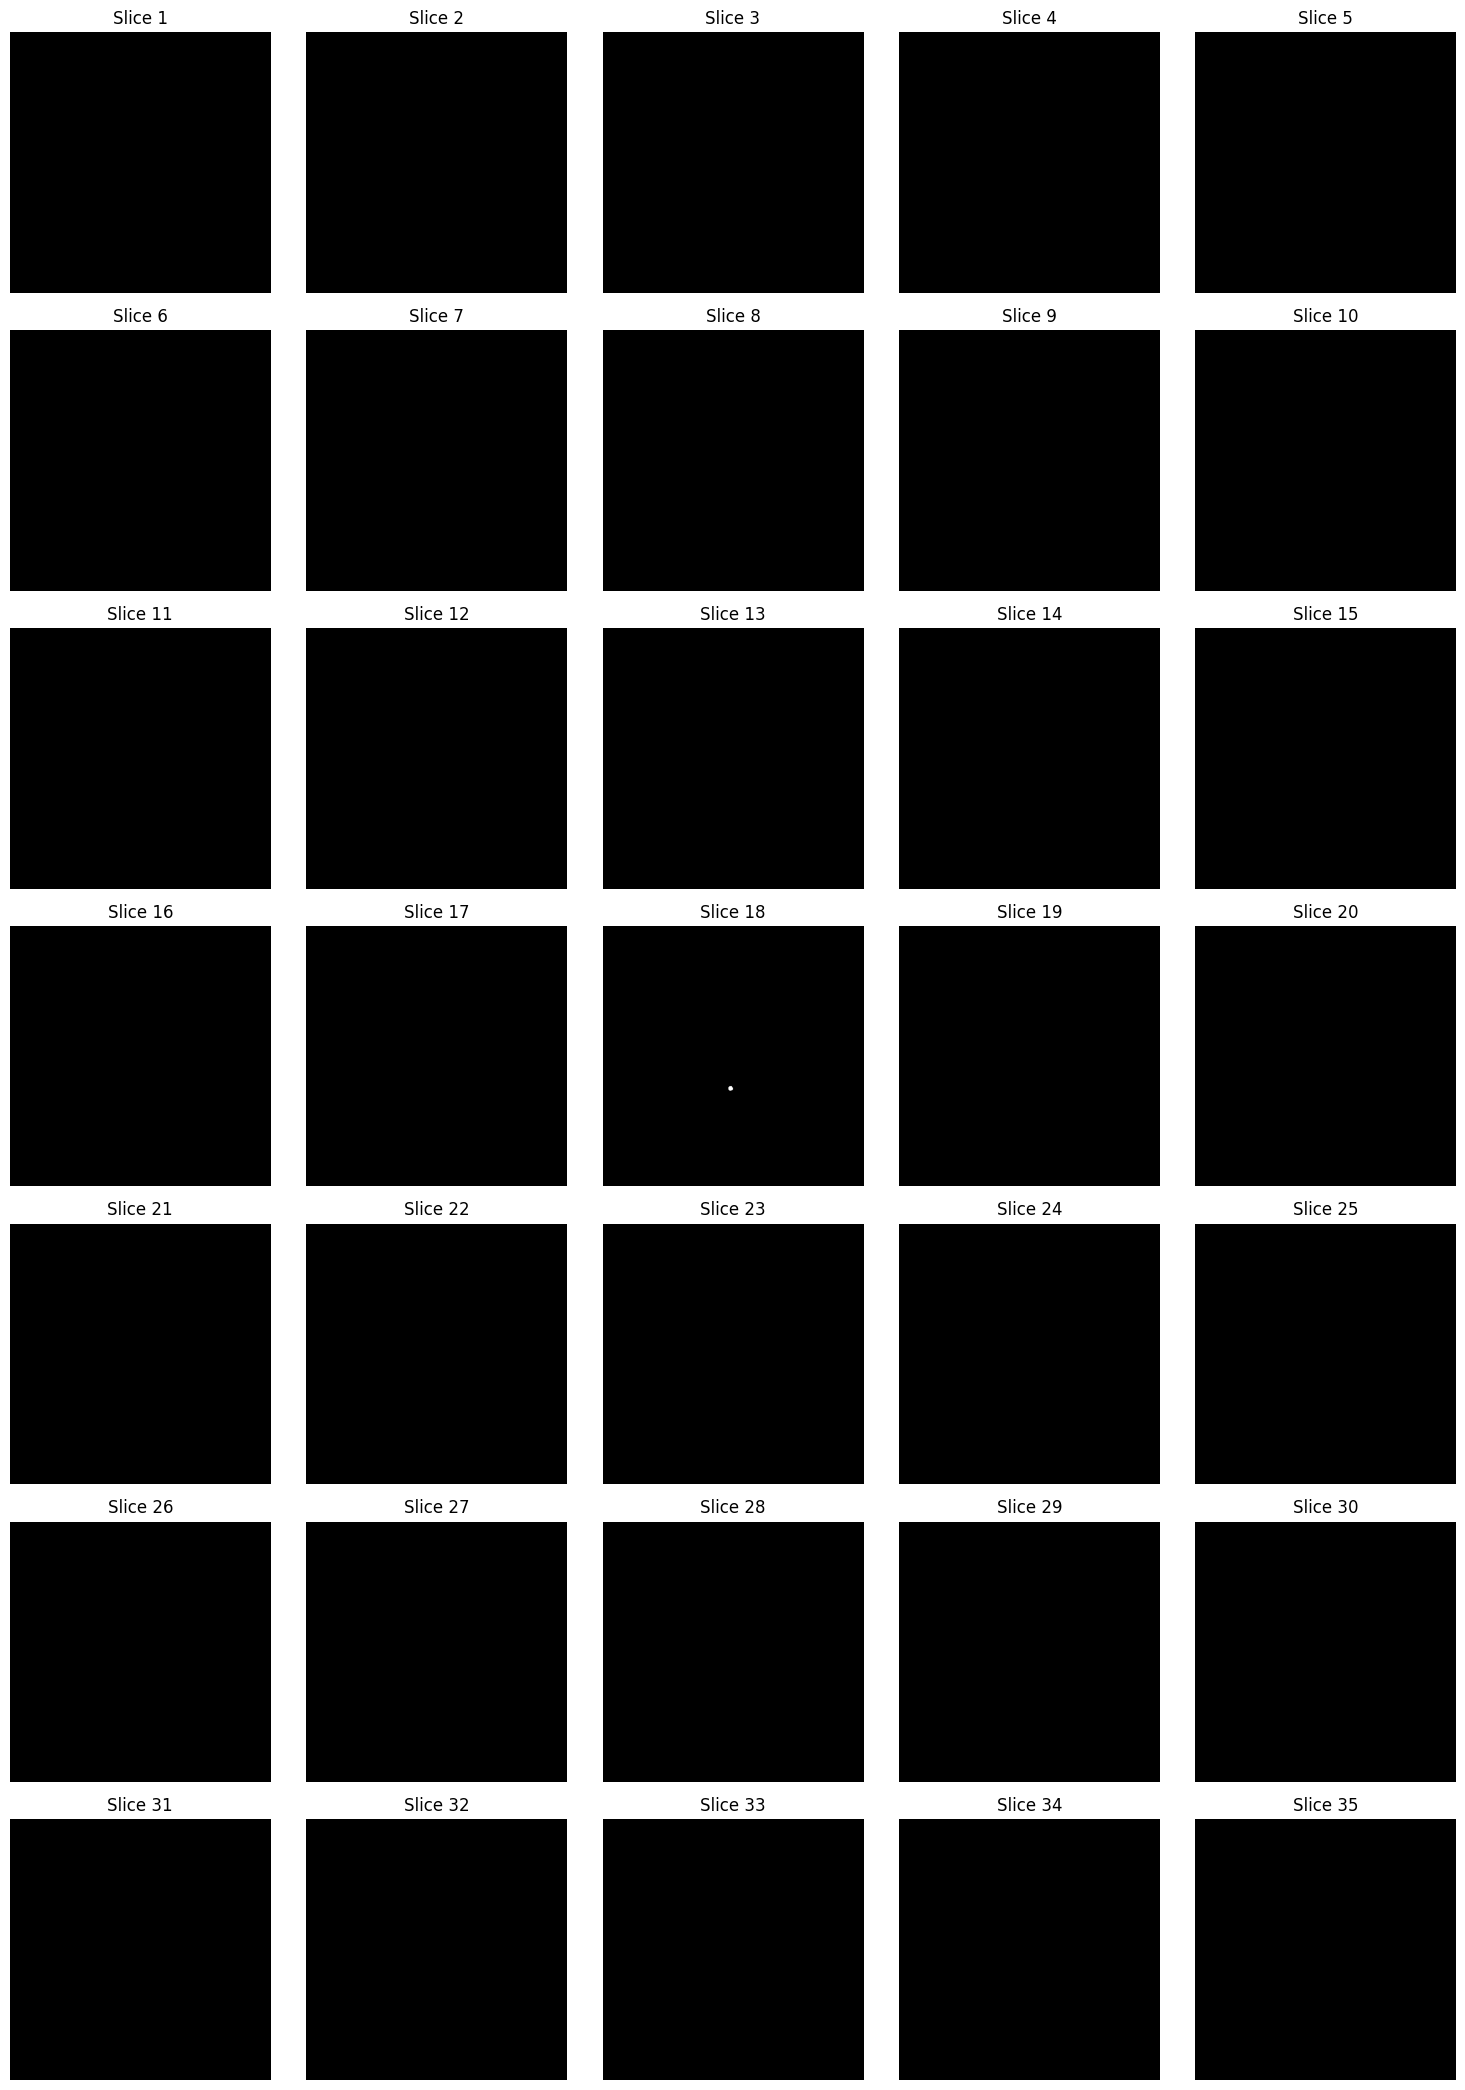

In [41]:
plot_all_slices(masks[1])